In [17]:

import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [18]:
BATCH_SIZE = 10 # the higher the better
IMG_WIDTH = 128 # for faster computing 
IMG_HEIGHT = 128 # for faster computing
IMG_CHANNELS = 3
TRAIN_PATH = 'Datasets/nucleus/'
TEST_PATH = 'Datasets/test/'
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

In [19]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
np.random.seed(10)

In [20]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask
    
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 24/24 [00:03<00:00,  6.19it/s]

Getting and resizing test images ... 



100%|██████████| 6/6 [00:00<00:00,  7.62it/s]

Done!


In [21]:
from keras.preprocessing import image

# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

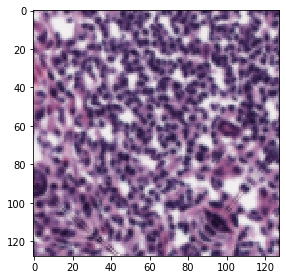

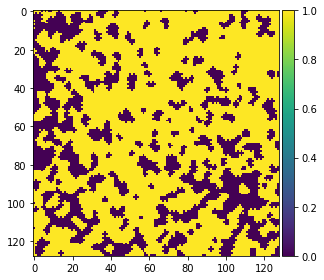

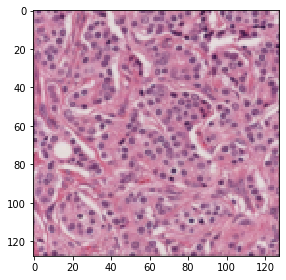

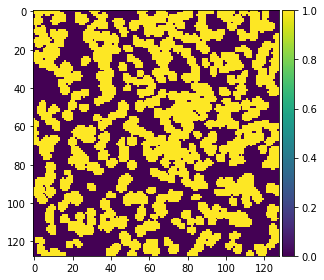

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

imshow(x.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()
imshow(x_val.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

In [23]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [24]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.compat.v1.to_int32(y_pred > t)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [55]:
activations = ['relu', 'elu']
dropouts = [0.1 ,0.3, 0.6, 0.9]
initializers = ['he_normal', 'lecun_normal']
epochs = [5,10,25]
validations = [25]
per_epoch = [250]

In [ ]:
        for a in activations:
            for b in activations:
                for c in activations:
                    for i in activations:
                        for aa in initializers:
                            for ab in initializers:
                                for ac in initializers:
                                    for da in dropouts:
                                        for dd in dropouts:
                                            for epo in epochs:
                                                inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
                                                s = Lambda(lambda x: x / 255) (inputs)
                                                c1 = Conv2D(16, (3, 3), activation=a, kernel_initializer=aa, padding='same') (s)
                                                c1 = Dropout(da) (c1)
                                                c1 = Conv2D(16, (3, 3), activation=b, kernel_initializer=ab, padding='same') (c1)
                                                p1 = MaxPooling2D((2, 2)) (c1)
                                                c2 = Conv2D(32, (3, 3), activation=c, kernel_initializer=ac, padding='same') (p1)
                                                c2 = Dropout(da) (c2)
                                                c2 = Conv2D(32, (3, 3), activation=a, kernel_initializer=aa, padding='same') (c2)
                                                p2 = MaxPooling2D((2, 2)) (c2)
                                                c3 = Conv2D(64, (3, 3), activation=b, kernel_initializer=ab, padding='same') (p2)
                                                c3 = Dropout(da) (c3)
                                                c3 = Conv2D(64, (3, 3), activation=c, kernel_initializer=ac, padding='same') (c3)
                                                p3 = MaxPooling2D((2, 2)) (c3)
                                                c4 = Conv2D(128, (3, 3), activation=a, kernel_initializer=aa, padding='same') (p3)
                                                c4 = Dropout(dd) (c4)
                                                c4 = Conv2D(128, (3, 3), activation=b, kernel_initializer=ab, padding='same') (c4)         
                                                p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
                                                c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
                                                c5 = Dropout(dd) (c5)
                                                c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)                                                                                                          
                                                u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
                                                u6 = concatenate([u6, c4])
                                                c6 = Conv2D(128, (3, 3), activation=b, kernel_initializer=ab, padding='same') (u6)
                                                c6 = Dropout(dd) (c6)                                                                                                            
                                                c6 = Conv2D(128, (3, 3), activation=a, kernel_initializer=aa, padding='same') (c6)
                                                u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
                                                u7 = concatenate([u7, c3])
                                                c7 = Conv2D(64, (3, 3), activation=c, kernel_initializer=ac, padding='same') (u7)                                                                                                            
                                                c7 = Dropout(da) (c7)
                                                c7 = Conv2D(64, (3, 3), activation=b, kernel_initializer=ab, padding='same') (c7)
                                                u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
                                                u8 = concatenate([u8, c2])                                                                                                            
                                                c8 = Conv2D(32, (3, 3), activation=a, kernel_initializer=aa, padding='same') (u8)
                                                c8 = Dropout(da) (c8)
                                                c8 = Conv2D(32, (3, 3), activation=c, kernel_initializer=ac, padding='same') (c8)
                                                u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)                                                                                                            
                                                u9 = concatenate([u9, c1], axis=3)
                                                c9 = Conv2D(16, (3, 3), activation=b, kernel_initializer=ab, padding='same') (u9)
                                                c9 = Dropout(da) (c9)
                                                c9 = Conv2D(16, (3, 3), activation=a, kernel_initializer=aa, padding='same') (c9)                                                                                                            
                                                outputs = Conv2D(1, (1, 1), activation=i) (c9)
                                                model = Model(inputs=[inputs], outputs=[outputs])
                                                model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
                                                model.summary()                                                                                                            
                                                earlystopper = EarlyStopping(patience=20, verbose=1)
                                                results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=25, steps_per_epoch=50, epochs=epo, callbacks=[earlystopper])

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_28 (Lambda)              (None, 128, 128, 3)  0           input_28[0][0]                   
__________________________________________________________________________________________________
conv2d_514 (Conv2D)             (None, 128, 128, 16) 448         lambda_28[0][0]                  
__________________________________________________________________________________________________
dropout_244 (Dropout)           (None, 128, 128, 16) 0           conv2d_514[0][0]                 
___________________________________________________________________________________________

Epoch 1/5
50/50 [==============================] - 33s 669ms/step - loss: 0.9844 - mean_iou: 0.2565 - val_loss: 0.7633 - val_mean_iou: 0.2485
Epoch 2/5
50/50 [==============================] - 30s 592ms/step - loss: 0.7575 - mean_iou: 0.2623 - val_loss: 0.8434 - val_mean_iou: 0.2712
Epoch 3/5
50/50 [==============================] - 30s 593ms/step - loss: 0.6708 - mean_iou: 0.2777 - val_loss: 0.5320 - val_mean_iou: 0.2966
Epoch 4/5
50/50 [==============================] - 30s 606ms/step - loss: 0.5795 - mean_iou: 0.3152 - val_loss: 0.4881 - val_mean_iou: 0.3331
Epoch 5/5
50/50 [==============================] - 30s 593ms/step - loss: 0.6010 - mean_iou: 0.3429 - val_loss: 0.4920 - val_mean_iou: 0.3528
Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 128, 128, 3)  0                    

Epoch 1/10
50/50 [==============================] - 33s 667ms/step - loss: 1.0430 - mean_iou: 0.2721 - val_loss: 0.6400 - val_mean_iou: 0.2738
Epoch 2/10
50/50 [==============================] - 32s 640ms/step - loss: 0.6566 - mean_iou: 0.2874 - val_loss: 0.5301 - val_mean_iou: 0.3134
Epoch 3/10
50/50 [==============================] - 30s 591ms/step - loss: 0.6393 - mean_iou: 0.3279 - val_loss: 0.5478 - val_mean_iou: 0.3364
Epoch 4/10
50/50 [==============================] - 30s 605ms/step - loss: 0.5659 - mean_iou: 0.3517 - val_loss: 0.4972 - val_mean_iou: 0.3661
Epoch 5/10
50/50 [==============================] - 30s 592ms/step - loss: 0.5630 - mean_iou: 0.3755 - val_loss: 0.5125 - val_mean_iou: 0.3831
Epoch 6/10
50/50 [==============================] - 30s 591ms/step - loss: 0.5417 - mean_iou: 0.3894 - val_loss: 0.4674 - val_mean_iou: 0.3977
Epoch 7/10
50/50 [==============================] - 30s 606ms/step - loss: 0.5199 - mean_iou: 0.4048 - val_loss: 0.4730 - val_mean_iou: 0.4111

Epoch 1/25
50/50 [==============================] - 33s 658ms/step - loss: 2.7923 - mean_iou: 0.2810 - val_loss: 0.7426 - val_mean_iou: 0.2727
Epoch 2/25
50/50 [==============================] - 30s 601ms/step - loss: 0.6871 - mean_iou: 0.2799 - val_loss: 0.6189 - val_mean_iou: 0.2994
Epoch 3/25
50/50 [==============================] - 29s 589ms/step - loss: 0.6267 - mean_iou: 0.3155 - val_loss: 0.6709 - val_mean_iou: 0.3241
Epoch 4/25
50/50 [==============================] - 30s 590ms/step - loss: 0.6243 - mean_iou: 0.3281 - val_loss: 0.5649 - val_mean_iou: 0.3353
Epoch 5/25
50/50 [==============================] - 30s 604ms/step - loss: 0.5586 - mean_iou: 0.3448 - val_loss: 0.5045 - val_mean_iou: 0.3543
Epoch 6/25
50/50 [==============================] - 29s 589ms/step - loss: 0.5407 - mean_iou: 0.3628 - val_loss: 0.5044 - val_mean_iou: 0.3699
Epoch 7/25
50/50 [==============================] - 29s 590ms/step - loss: 0.5313 - mean_iou: 0.3762 - val_loss: 0.5169 - val_mean_iou: 0.3815

Epoch 1/5
50/50 [==============================] - 33s 666ms/step - loss: 0.9837 - mean_iou: 0.2567 - val_loss: 0.7193 - val_mean_iou: 0.2524
Epoch 2/5
50/50 [==============================] - 29s 588ms/step - loss: 0.6529 - mean_iou: 0.2726 - val_loss: 0.5520 - val_mean_iou: 0.3022
Epoch 3/5
50/50 [==============================] - 30s 603ms/step - loss: 0.6019 - mean_iou: 0.3209 - val_loss: 0.5108 - val_mean_iou: 0.3406
Epoch 4/5
50/50 [==============================] - 29s 590ms/step - loss: 0.7479 - mean_iou: 0.3481 - val_loss: 0.6279 - val_mean_iou: 0.3437
Epoch 5/5
50/50 [==============================] - 30s 591ms/step - loss: 0.5916 - mean_iou: 0.3474 - val_loss: 0.5141 - val_mean_iou: 0.3553
Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 128, 128, 3)  0                    

Epoch 1/10
50/50 [==============================] - 34s 671ms/step - loss: 1.0309 - mean_iou: 0.2563 - val_loss: 0.7260 - val_mean_iou: 0.2576
Epoch 2/10
50/50 [==============================] - 29s 587ms/step - loss: 0.7002 - mean_iou: 0.2707 - val_loss: 0.5918 - val_mean_iou: 0.2923
Epoch 3/10
50/50 [==============================] - 30s 605ms/step - loss: 0.6148 - mean_iou: 0.3094 - val_loss: 0.5158 - val_mean_iou: 0.3318
Epoch 4/10
50/50 [==============================] - 29s 590ms/step - loss: 0.5868 - mean_iou: 0.3435 - val_loss: 0.5362 - val_mean_iou: 0.3563
Epoch 5/10
50/50 [==============================] - 30s 592ms/step - loss: 0.5862 - mean_iou: 0.3659 - val_loss: 0.5236 - val_mean_iou: 0.3740
Epoch 6/10
50/50 [==============================] - 30s 604ms/step - loss: 0.5703 - mean_iou: 0.3805 - val_loss: 0.5510 - val_mean_iou: 0.3862
Epoch 7/10
50/50 [==============================] - 30s 591ms/step - loss: 0.5521 - mean_iou: 0.3905 - val_loss: 0.5042 - val_mean_iou: 0.3960

Epoch 1/25
50/50 [==============================] - 34s 685ms/step - loss: 0.9975 - mean_iou: 0.2529 - val_loss: 0.5571 - val_mean_iou: 0.2929
Epoch 2/25
50/50 [==============================] - 29s 586ms/step - loss: 0.6308 - mean_iou: 0.3214 - val_loss: 0.6246 - val_mean_iou: 0.3345
Epoch 3/25
50/50 [==============================] - 30s 592ms/step - loss: 0.5630 - mean_iou: 0.3464 - val_loss: 0.5010 - val_mean_iou: 0.3642
Epoch 4/25
50/50 [==============================] - 30s 606ms/step - loss: 0.5404 - mean_iou: 0.3774 - val_loss: 0.4763 - val_mean_iou: 0.3897
Epoch 5/25
50/50 [==============================] - 30s 590ms/step - loss: 0.5238 - mean_iou: 0.3990 - val_loss: 0.5034 - val_mean_iou: 0.4054
Epoch 6/25
50/50 [==============================] - 30s 593ms/step - loss: 0.5465 - mean_iou: 0.4090 - val_loss: 0.5235 - val_mean_iou: 0.4118
Epoch 7/25
50/50 [==============================] - 30s 607ms/step - loss: 0.5275 - mean_iou: 0.4146 - val_loss: 0.4926 - val_mean_iou: 0.4190

Epoch 1/5
50/50 [==============================] - 34s 675ms/step - loss: 0.8860 - mean_iou: 0.2719 - val_loss: 0.5876 - val_mean_iou: 0.2992
Epoch 2/5
50/50 [==============================] - 30s 602ms/step - loss: 0.5972 - mean_iou: 0.3293 - val_loss: 0.5372 - val_mean_iou: 0.3540
Epoch 3/5
50/50 [==============================] - 30s 595ms/step - loss: 0.5936 - mean_iou: 0.3641 - val_loss: 0.5888 - val_mean_iou: 0.3745
Epoch 4/5
50/50 [==============================] - 30s 594ms/step - loss: 0.5767 - mean_iou: 0.3779 - val_loss: 0.5996 - val_mean_iou: 0.3822
Epoch 5/5
50/50 [==============================] - 30s 609ms/step - loss: 0.5863 - mean_iou: 0.3811 - val_loss: 0.5915 - val_mean_iou: 0.3820
Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 128, 128, 3)  0                    

Epoch 1/10
50/50 [==============================] - 34s 678ms/step - loss: 1.2043 - mean_iou: 0.2672 - val_loss: 0.7310 - val_mean_iou: 0.2573
Epoch 2/10
50/50 [==============================] - 30s 599ms/step - loss: 0.7121 - mean_iou: 0.2636 - val_loss: 0.7320 - val_mean_iou: 0.2770
Epoch 3/10
50/50 [==============================] - 30s 592ms/step - loss: 0.6363 - mean_iou: 0.2856 - val_loss: 0.6401 - val_mean_iou: 0.3015
Epoch 4/10
50/50 [==============================] - 30s 591ms/step - loss: 0.6066 - mean_iou: 0.3118 - val_loss: 0.5326 - val_mean_iou: 0.3249
Epoch 5/10
50/50 [==============================] - 30s 603ms/step - loss: 0.5542 - mean_iou: 0.3374 - val_loss: 0.5467 - val_mean_iou: 0.3480
Epoch 6/10
50/50 [==============================] - 29s 590ms/step - loss: 0.5475 - mean_iou: 0.3559 - val_loss: 0.5343 - val_mean_iou: 0.3624
Epoch 7/10
50/50 [==============================] - 30s 592ms/step - loss: 0.5324 - mean_iou: 0.3684 - val_loss: 0.4716 - val_mean_iou: 0.3750

Epoch 1/25
50/50 [==============================] - 34s 680ms/step - loss: 5.0322 - mean_iou: 0.2788 - val_loss: 5.6214 - val_mean_iou: 0.2771
Epoch 2/25
50/50 [==============================] - 29s 585ms/step - loss: 5.1861 - mean_iou: 0.2781 - val_loss: 1.0404 - val_mean_iou: 0.2915
Epoch 3/25
50/50 [==============================] - 30s 605ms/step - loss: 0.7978 - mean_iou: 0.3142 - val_loss: 0.7488 - val_mean_iou: 0.3256
Epoch 4/25
50/50 [==============================] - 30s 591ms/step - loss: 0.6698 - mean_iou: 0.3314 - val_loss: 0.6944 - val_mean_iou: 0.3375
Epoch 5/25
50/50 [==============================] - 30s 594ms/step - loss: 0.5829 - mean_iou: 0.3443 - val_loss: 0.6192 - val_mean_iou: 0.3511
Epoch 6/25
50/50 [==============================] - 30s 606ms/step - loss: 0.5570 - mean_iou: 0.3557 - val_loss: 0.5241 - val_mean_iou: 0.3624
Epoch 7/25
50/50 [==============================] - 30s 592ms/step - loss: 0.5300 - mean_iou: 0.3685 - val_loss: 0.5512 - val_mean_iou: 0.3739

Epoch 1/5
50/50 [==============================] - 35s 696ms/step - loss: 5.3453 - mean_iou: 0.3066 - val_loss: 4.1919 - val_mean_iou: 0.2979
Epoch 2/5
50/50 [==============================] - 29s 580ms/step - loss: 5.0677 - mean_iou: 0.2952 - val_loss: 3.8885 - val_mean_iou: 0.2919
Epoch 3/5
50/50 [==============================] - 29s 583ms/step - loss: 5.2450 - mean_iou: 0.2905 - val_loss: 4.4439 - val_mean_iou: 0.2886
Epoch 4/5
50/50 [==============================] - 30s 598ms/step - loss: 5.2507 - mean_iou: 0.2878 - val_loss: 0.8091 - val_mean_iou: 0.2888
Epoch 5/5
50/50 [==============================] - 29s 587ms/step - loss: 1.4405 - mean_iou: 0.3028 - val_loss: 0.6453 - val_mean_iou: 0.3151
Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           (None, 128, 128, 3)  0                    

Epoch 1/10
50/50 [==============================] - 35s 695ms/step - loss: 4.7015 - mean_iou: 0.3092 - val_loss: 1.1925 - val_mean_iou: 0.3192
Epoch 2/10
50/50 [==============================] - 29s 581ms/step - loss: 0.7287 - mean_iou: 0.3215 - val_loss: 0.5684 - val_mean_iou: 0.3269
Epoch 3/10
50/50 [==============================] - 29s 588ms/step - loss: 0.5760 - mean_iou: 0.3440 - val_loss: 0.5439 - val_mean_iou: 0.3592
Epoch 4/10
50/50 [==============================] - 30s 599ms/step - loss: 0.5401 - mean_iou: 0.3693 - val_loss: 0.4876 - val_mean_iou: 0.3834
Epoch 5/10
50/50 [==============================] - 29s 587ms/step - loss: 0.5279 - mean_iou: 0.3939 - val_loss: 0.4720 - val_mean_iou: 0.4036
Epoch 6/10
50/50 [==============================] - 29s 587ms/step - loss: 0.4995 - mean_iou: 0.4112 - val_loss: 0.4658 - val_mean_iou: 0.4184
Epoch 7/10
50/50 [==============================] - 30s 602ms/step - loss: 0.5431 - mean_iou: 0.4207 - val_loss: 0.4908 - val_mean_iou: 0.4235

Epoch 1/25
50/50 [==============================] - 38s 762ms/step - loss: 5.5251 - mean_iou: 0.3008 - val_loss: 5.6560 - val_mean_iou: 0.2901
Epoch 2/25
50/50 [==============================] - 33s 665ms/step - loss: 5.1810 - mean_iou: 0.2867 - val_loss: 5.6828 - val_mean_iou: 0.2836
Epoch 3/25
50/50 [==============================] - 31s 625ms/step - loss: 5.1903 - mean_iou: 0.2823 - val_loss: 5.6879 - val_mean_iou: 0.2807
Epoch 4/25
50/50 [==============================] - 30s 595ms/step - loss: 5.1164 - mean_iou: 0.2802 - val_loss: 5.6940 - val_mean_iou: 0.2794
Epoch 5/25
50/50 [==============================] - 30s 599ms/step - loss: 4.8464 - mean_iou: 0.2789 - val_loss: 5.6940 - val_mean_iou: 0.2784
Epoch 6/25
50/50 [==============================] - 29s 585ms/step - loss: 5.1647 - mean_iou: 0.2781 - val_loss: 5.6940 - val_mean_iou: 0.2777
Epoch 7/25
50/50 [==============================] - 29s 585ms/step - loss: 4.9977 - mean_iou: 0.2776 - val_loss: 5.6940 - val_mean_iou: 0.2773

Epoch 1/5
50/50 [==============================] - 35s 706ms/step - loss: 2.1500 - mean_iou: 0.2986 - val_loss: 0.8918 - val_mean_iou: 0.2828
Epoch 2/5
50/50 [==============================] - 29s 585ms/step - loss: 0.8163 - mean_iou: 0.2727 - val_loss: 0.7154 - val_mean_iou: 0.2695
Epoch 3/5
50/50 [==============================] - 30s 592ms/step - loss: 0.7373 - mean_iou: 0.2709 - val_loss: 0.7049 - val_mean_iou: 0.2723
Epoch 4/5
50/50 [==============================] - 30s 605ms/step - loss: 0.6881 - mean_iou: 0.2771 - val_loss: 0.6404 - val_mean_iou: 0.2831
Epoch 5/5
50/50 [==============================] - 30s 591ms/step - loss: 0.6547 - mean_iou: 0.2888 - val_loss: 0.6304 - val_mean_iou: 0.2953
Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           (None, 128, 128, 3)  0                    

Epoch 1/10
50/50 [==============================] - 36s 712ms/step - loss: 2.5249 - mean_iou: 0.2905 - val_loss: 0.9381 - val_mean_iou: 0.2765
Epoch 2/10
50/50 [==============================] - 30s 590ms/step - loss: 0.8209 - mean_iou: 0.2684 - val_loss: 0.8517 - val_mean_iou: 0.2676
Epoch 3/10
50/50 [==============================] - 30s 593ms/step - loss: 0.7235 - mean_iou: 0.2690 - val_loss: 0.7352 - val_mean_iou: 0.2731
Epoch 4/10
50/50 [==============================] - 30s 607ms/step - loss: 0.6604 - mean_iou: 0.2791 - val_loss: 0.6479 - val_mean_iou: 0.2863
Epoch 5/10
50/50 [==============================] - 30s 593ms/step - loss: 0.6323 - mean_iou: 0.2932 - val_loss: 0.5935 - val_mean_iou: 0.3019
Epoch 6/10
50/50 [==============================] - 30s 594ms/step - loss: 0.6435 - mean_iou: 0.3086 - val_loss: 0.8296 - val_mean_iou: 0.3105
Epoch 7/10
50/50 [==============================] - 31s 618ms/step - loss: 0.6820 - mean_iou: 0.3083 - val_loss: 0.5874 - val_mean_iou: 0.3097

Epoch 1/25
50/50 [==============================] - 35s 707ms/step - loss: 4.9047 - mean_iou: 0.3194 - val_loss: 1.2751 - val_mean_iou: 0.3222
Epoch 2/25
50/50 [==============================] - 32s 649ms/step - loss: 1.1257 - mean_iou: 0.3074 - val_loss: 0.9227 - val_mean_iou: 0.2977
Epoch 3/25
50/50 [==============================] - 72s 1s/step - loss: 0.7649 - mean_iou: 0.2941 - val_loss: 0.7152 - val_mean_iou: 0.2953
Epoch 4/25
50/50 [==============================] - 32s 633ms/step - loss: 0.6872 - mean_iou: 0.2989 - val_loss: 0.6900 - val_mean_iou: 0.3046
Epoch 5/25
50/50 [==============================] - 31s 614ms/step - loss: 0.6463 - mean_iou: 0.3101 - val_loss: 0.6114 - val_mean_iou: 0.3173
Epoch 6/25
50/50 [==============================] - 30s 599ms/step - loss: 0.6219 - mean_iou: 0.3226 - val_loss: 0.5926 - val_mean_iou: 0.3276
Epoch 7/25
50/50 [==============================] - 30s 598ms/step - loss: 0.6021 - mean_iou: 0.3323 - val_loss: 0.5902 - val_mean_iou: 0.3364
Ep

In [39]:
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

6/6 [==============================] - 0s 13ms/step


In [51]:
from PIL import Image
import numpy as np

for i in np.arange(5):
    array = np.array(preds_test_upsampled[i]*255, dtype = np.uint8)
    image = Image.fromarray(array)
    image.save('test %d .png' % i)
        